# PACE MOANA Data Visualization: Time Series & Hovmoller Diagrams
**Author:** Shailja Gangrade (Brown University). Adapted from Carina Poulin (NASA, SSAI). Prepared for the PACE Hackweek 2025.

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

<div class="alert alert-warning" role="alert">

You need up to 4GB of memory to run this notebook

</div>

[edl]: https://urs.earthdata.nasa.gov/

## Summary

[Add here]

## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values.
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

Set (and persist to your user profile on the host, if needed) your Earthdata Login credentials.

In [4]:
auth = earthaccess.login()

[back to top](#Contents)

## 2. Plot a timeline of the plankton types for a region of interest

We are going to use what we just learned to create a timeline for a chosen area. First, we will get data for the entire PACE mission to date.

### Get data

In [5]:
tspan = ("2024-04-01", "2025-05-31")

In [6]:
results_moana = earthaccess.search_data(
    short_name="PACE_OCI_L3M_MOANA",
    granule_name="*.Day.*0p1deg*",  # Daily: Day | Resolution: 0p1deg or 4 (for 4km)
    temporal=tspan,
)

Since we want to draw a timeline, we will get the date information from the dataset's attribute with the new function we are creating: `time_from_attr`.

In [7]:
def time_from_attr(ds):
    """Set the time attribute as a dataset variable
    Args:
        ds: a dataset corresponding to one or multiple Level-2 granules
    Returns:
        the dataset with a scalar "time" coordinate
    """
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    ds["date"] = ((), np.datetime64(datetime, "ns"))
    ds = ds.set_coords("date")
    return ds

In [8]:
path_files = earthaccess.open(results_moana)

QUEUEING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/376 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/376 [00:00<?, ?it/s]

We use `time_from_attr` in the `preprocess` parameter of `xr.open_mfdataset`. We then can see the date coordinate added to the dataset.

In [9]:
dataset_moana = xr.open_mfdataset(
    path_files, preprocess=time_from_attr, combine="nested", concat_dim="date"
)
dataset_moana

<xarray.Dataset> Size: 7GB
Dimensions:          (date: 376, lat: 1400, lon: 1100, rgb: 3,
                      eightbitcolor: 256)
Coordinates:
  * lat              (lat) float32 6kB 69.95 69.85 69.75 ... -69.85 -69.95
  * lon              (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.85 24.95
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    prococcus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette          (date, rgb, eightbitcolor) uint8 289kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

### Clean up data

We then clean up our dataset using the built-in `valid_min` and `valid_max` values and remove the palette variable that we will not be using.

In [10]:
dataset_moana["prococcus_moana"] = dataset_moana["prococcus_moana"].clip(
    min=dataset_moana["prococcus_moana"].attrs["valid_min"],
    max=dataset_moana["prococcus_moana"].attrs["valid_max"],
)
dataset_moana["syncoccus_moana"] = dataset_moana["syncoccus_moana"].clip(
    min=dataset_moana["syncoccus_moana"].attrs["valid_min"],
    max=dataset_moana["syncoccus_moana"].attrs["valid_max"],
)
dataset_moana["picoeuk_moana"] = dataset_moana["picoeuk_moana"].clip(
    min=dataset_moana["picoeuk_moana"].attrs["valid_min"],
    max=dataset_moana["picoeuk_moana"].attrs["valid_max"],
)

In [11]:
dataset_phy = dataset_moana.drop_vars(["palette"])

Let's average, normalize and reorder our dataset as seen in the previous example.

In [12]:
dataset_phy_mean = dataset_phy.mean("date")
dataset_phy_mean = dataset_phy_mean.astype(np.float64)
dataset_norm = (
    (dataset_phy_mean - dataset_phy_mean.min())
    / (dataset_phy_mean.max() - dataset_phy_mean.min())
)
data_norm = dataset_norm.to_dataarray()
data_norm = data_norm.sel(
    variable=["syncoccus_moana", "picoeuk_moana", "prococcus_moana"]
)

In [13]:
data_norm

<xarray.DataArray (variable: 3, lat: 1400, lon: 1100)> Size: 37MB
dask.array<getitem, shape=(3, 1400, 1100), dtype=float64, chunksize=(1, 512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 6kB 69.95 69.85 69.75 69.65 ... -69.75 -69.85 -69.95
  * lon       (lon) float32 4kB -84.95 -84.85 -84.75 ... 24.75 24.85 24.95
  * variable  (variable) object 24B 'syncoccus_moana' ... 'prococcus_moana'

### Select and visualize our region of interest: the AMT sampling transect region

We want to select the AMT sampling transect region. How do we define this? Let's use the AMT28 (highly resolved transect) latitude and longitude points (read in from CSV file).

For bounding boxes, use signs appropriately: 

North latitude is positive, South latitude is negative. 
East longitude is positive, West longitude is negative.

#### Option 1: Take the entire box around AMT28 locations.

In [14]:
AMT_df = pd.read_csv('AMT28_underway_latlon.csv')
AMT_df

AMT_df.Lon[AMT_df.Lon<-60]= np.nan # Clean erroneous longitude data

# Identify the bounding box of AMT28 data:
west_lon = min(AMT_df.Lon)
south_lat = min(AMT_df.Lat)
east_lon = max(AMT_df.Lon)
north_lat = max(AMT_df.Lat)

west_lon, south_lat, east_lon, north_lat

(-52.692, -48.199, -5.502, 49.638)

In [ ]:
# def find_nearest_point_numpy(target_point, points_array):
#     """
#     Finds the nearest point to a target_point from a NumPy array of points.
#     target_point: (x, y) tuple or NumPy array
#     points_array: NumPy array of shape (n, 2)
#     """
#     distances = np.linalg.norm(points_array - target_point, axis=1)
#     nearest_index = np.argmin(distances)
#     return points_array[nearest_index]

# target_np = np.array([0, 0])
# data_points_np = np.array([[1, 3], [-2, 2], [5, -1], [3, 2], [1, 1]])
# closest_np = find_nearest_point_numpy(target_np, data_points_np)
# print(f"The nearest point to {target_np} is {closest_np}")

# # Example usage
# target_np = np.array([0, 0])
# data_points_np = np.array([[1, 3], [-2, 2], [5, -1], [3, 2], [1, 1]])
# closest_np = find_nearest_point_numpy(target_np, data_points_np)
# print(f"The nearest point to {target_np} is {closest_np}")


#     da = data_norm.sel(variable=varname)
#     interp_result_pro = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()


#### Option 2: Take the nearest-neighbor grid points (from PACE) to the AMT28 sampling locations.

In [19]:
# # Load and duplicate lat/lon points (code from Olivia)
# points_df = pd.read_csv("AMT28_underway_latlon.csv").drop_duplicates(subset=["Lat", "Lon"]).reset_index(drop=True)
# points_df["point"] = np.arange(len(points_df))

# # Create point-indexed lat/lon DataArrays (code from Olivia)
# lat_da = xr.DataArray(points_df["Lat"].values, dims="point")
# lon_da = xr.DataArray(points_df["Lon"].values, dims="point")

# varnames = list(data_norm["variable"].values)

# # Storage for output DataFrames (code from Olivia)
# all_dfs = []

# for varname in varnames:
#     print(f"Extracting: {varname}")

#     # Subset to one  variable
#     da = data_norm.sel(variable=varname)

#     # extract using nearest neighbor (date, point)
#     interp_result = da.sel(lat=lat_da, lon=lon_da, method="nearest").compute()

#     # Convert to df and merge lat/lon back in
#     interp_df = interp_result.to_dataframe(name=varname).reset_index()
#     interp_df = interp_df.merge(points_df, on="point")[["Lat", "Lon", varname]]

#     all_dfs.append(interp_df)

# # Merge all variable DataFrames on lat/lon (code from Olivia)
# final_df = all_dfs[0]
# for df in all_dfs[1:]:
#     final_df = final_df.merge(df, on=["Lat", "Lon"])


Here is an entirely optional check for your coordinates.

In [23]:
if south_lat > north_lat:
    south_lat, north_lat = north_lat, south_lat
    print("Warning: South latitude was north of north latitude. Values swapped.")

if west_lon > east_lon:
    if abs(west_lon - east_lon) > 180:
        print("Box appears to cross the antimeridian (180/-180 line).")
    else:
        west_lon, east_lon = east_lon, west_lon
        print("Warning: West longitude was east of east longitude. Values swapped.")

lat_ascending = dataset_phy["lat"][1] > dataset_phy["lat"][0]
lon_ascending = dataset_phy.lon[1] > dataset_phy.lon[0]

if lat_ascending:
    lat_min = south_lat
    lat_max = north_lat
else:
    lat_min = north_lat
    lat_max = south_lat

if lon_ascending:
    lon_min = west_lon
    lon_max = east_lon
else:
    lon_min = east_lon
    lon_max = west_lon

Then we plot a rectangle around our area of interest on our RGB map. We can try to choose an area that is at the edge of a population to see the changes in time.

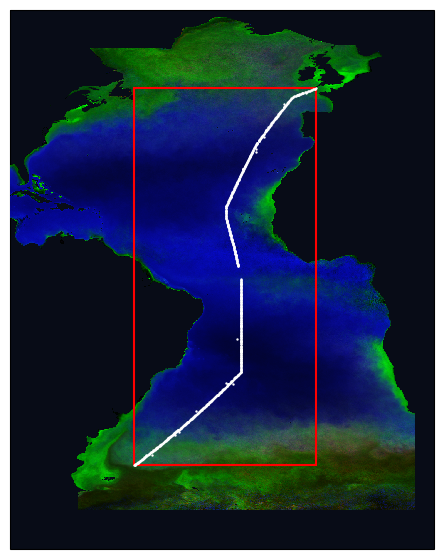

In [26]:
fig = plt.figure(figsize=(7, 7))
ax1 = fig.add_subplot(projection=ccrs.PlateCarree(), facecolor="#080c17")
ax2 = data_norm.plot.imshow(
    transform=ccrs.PlateCarree(), interpolation="none", zorder=3
)

# Add bounding box
ax1.add_patch(
    Rectangle(
        (lon_min, lat_min),
        lon_max - lon_min,
        lat_max - lat_min,
        edgecolor="red",
        facecolor="none",
        linewidth=1.5,
        transform=ccrs.PlateCarree(),
        zorder=4,
    )
)

ax1.scatter(AMT_df.Lon, AMT_df.Lat, color='white', marker='o', s=0.5, transform=ccrs.PlateCarree(), label='AMT', zorder=5)

plt.show()



In [28]:
fig.savefig("moana_snapshot_withAMTstns_boundingbox" + str(tspan) + ".png", format="png", dpi=600)

We then select the data within our area of interest (bounding box option).

In [29]:
tl = dataset_phy.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
tl

<xarray.Dataset> Size: 2GB
Dimensions:          (date: 376, lat: 978, lon: 472)
Coordinates:
  * lat              (lat) float32 4kB 49.55 49.45 49.35 ... -48.05 -48.15
  * lon              (lon) float32 2kB -52.65 -52.55 -52.45 ... -5.65 -5.55
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
    syncoccus_moana  (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
    picoeuk_moana    (date, lat, lon) float32 694MB dask.array<chunksize=(1, 308, 472), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240401.L3m.DAY.MOANA.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/MOANA/3.0
    data_bins:                         166600
    data_minimum:                      -inf
    data_maximum:                      inf

### Plot the timelines with spatial averages and standard deviations

We want to run some statistics within our area. Here we are looking at the average and standard deviation for each group.

In [30]:
region_mean = tl.mean(dim=["lat", "lon"])
region_std = tl.std(dim=["lat", "lon"])

lon_mean = tl.mean(dim=["lon"])
lon_std = tl.std(dim=["lon"])

In [31]:
region_mean.load()
region_std.load()

lon_mean.load()
lon_std.load()

<xarray.Dataset> Size: 4MB
Dimensions:          (date: 376, lat: 978)
Coordinates:
  * lat              (lat) float32 4kB 49.55 49.45 49.35 ... -48.05 -48.15
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat) float32 1MB 9.936e+04 8.653e+04 ... 0.0 nan
    syncoccus_moana  (date, lat) float32 1MB 2.299e+04 3.098e+04 ... 0.0 nan
    picoeuk_moana    (date, lat) float32 1MB 9.061e+03 7.232e+03 ... 0.0 nan

In [74]:
region_mean

<xarray.Dataset> Size: 8kB
Dimensions:          (date: 376)
Coordinates:
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date) float32 2kB 2.342e+05 2.229e+05 ... 2.452e+05
    syncoccus_moana  (date) float32 2kB 1.859e+04 1.856e+04 ... 1.011e+04
    picoeuk_moana    (date) float32 2kB 6.456e+03 5.933e+03 ... 3.296e+03

In [75]:
lon_mean

<xarray.Dataset> Size: 4MB
Dimensions:          (date: 376, lat: 978)
Coordinates:
  * lat              (lat) float32 4kB 49.55 49.45 49.35 ... -48.05 -48.15
  * date             (date) datetime64[ns] 3kB 2024-04-01T11:01:27 ... 2025-0...
Data variables:
    prococcus_moana  (date, lat) float32 1MB 1.568e+05 1.695e+05 ... 0.0 nan
    syncoccus_moana  (date, lat) float32 1MB 2.728e+04 3.057e+04 ... nan
    picoeuk_moana    (date, lat) float32 1MB 1.104e+04 8.661e+03 ... nan

In [79]:
lon_mean_df = lon_mean.to_dataframe()
lon_mean_df

prococcus_moana  syncoccus_moana  \
date                lat                                            
2024-04-01 11:01:27  49.549999    156828.218750     27284.451172   
                     49.450001    169521.765625     30568.955078   
                     49.349998    181585.781250     33737.402344   
                     49.250000    185648.203125     36565.214844   
                     49.150002    223645.843750     38168.703125   
...                                         ...              ...   
2025-05-01 10:28:24 -47.750000      1759.162354     29493.515625   
                    -47.850002     46410.804688     25947.503906   
                    -47.950001         0.000000      7970.620605   
                    -48.050003         0.000000     43129.574219   
                    -48.150002              NaN              NaN   

                                picoeuk_moana  
date                lat                        
2024-04-01 11:01:27  49.549999   11038.575195  
                     49.450001    8660.858398  
                     49.349998    9495.095703  
                     49.250000    8280.907227  
                     49.150002    7220.454590  
...                                       ...  
2025-05-01 10:28:24 -47.750000    5255.545898  
                    -47.850002    5088.725098  
                    -47.950001    8260.412109  
                    -48.050003    6875.636719  
                    -48.150002            NaN  

[367728 rows x 3 columns]

We can now plot our timeline. We are going to plot the standard deviations as a shaded area around our mean with `fill_between`. We are using `seaborn` as `sns` to get their built-in plot styling options. It can be good to define some style elements, like `markersize`, ahead to avoid repeating them, but they can be changed for any individual dataset if needed. 

In this case, we also are drawing a second y axis with `twinx` for prochlorococcus, which has much higher concentrations than synechococcus and picoeukaryotes.

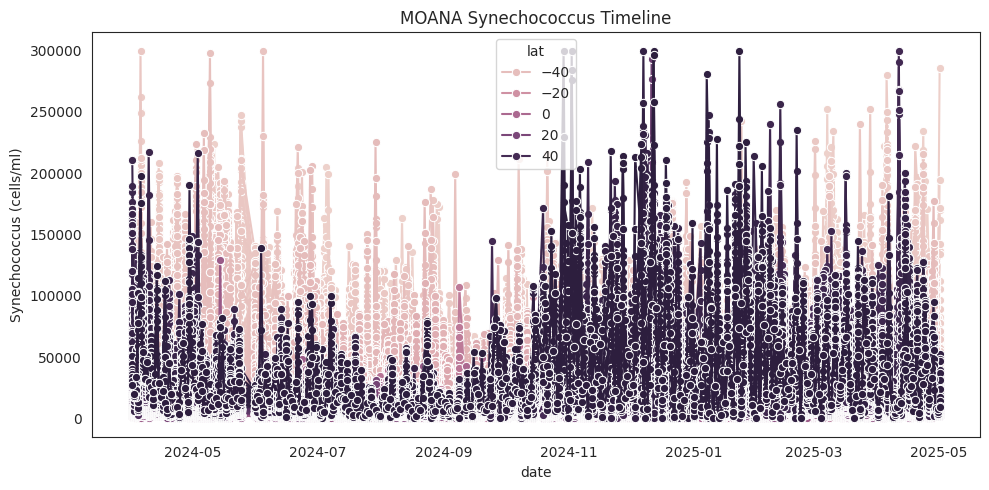

In [81]:
from matplotlib import cm

# colors = cm.viridis(

fig, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 2
marker = "o"
sns.set_style("white")
palette = sns.color_palette("husl", 3)

# Line plots of longitudinal averaged SYN data, colored by latitude
sns.lineplot(data=lon_mean_df, x="date", y='syncoccus_moana', hue='lat', marker='o')

ax1.set_ylabel("Synechococcus (cells/ml)")
plt.title("MOANA Synechococcus Timeline")
plt.tight_layout()
plt.show()

# Left y-axis plots
# ax1.plot(
#     lon_mean["syncoccus_moana"].date,
#     lon_mean["syncoccus_moana"][:,0], 
#     # c=colors[iLat],
#     marker=marker,
#     label="Syn",
#     linewidth=linewidth,
#     markersize=markersize,
# )

# Plot multiple lines colored by 'category'

# plt.title('Multiple Lines Colored by Category')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(title='Category')
# plt.grid(True)
# plt.show()



# ax1.fill_between(
#     region_mean["syncoccus_moana"].date,
#     region_mean["syncoccus_moana"] - region_std["syncoccus_moana"],
#     region_mean["syncoccus_moana"] + region_std["syncoccus_moana"],
#     color=palette[0],
#     alpha=0.2,
# )

# ax1.plot(
#     region_mean["picoeuk_moana"].date,
#     region_mean["picoeuk_moana"],
#     color=palette[1],
#     marker=marker,
#     label="Pico",
#     linewidth=linewidth,
#     markersize=markersize,
# )
# ax1.fill_between(
#     region_mean["picoeuk_moana"].date,
#     region_mean["picoeuk_moana"] - region_std["picoeuk_moana"],
#     region_mean["picoeuk_moana"] + region_std["picoeuk_moana"],
#     color=palette[1],
#     alpha=0.2,
# )

# # Right y-axis plot
# ax2 = ax1.twinx()
# ax2.plot(
#     region_mean["prococcus_moana"].date,
#     region_mean["prococcus_moana"],
#     color=palette[2],
#     marker=marker,
#     linestyle="--",
#     label="Pro",
#     linewidth=linewidth,
#     markersize=markersize,
# )
# ax2.fill_between(
#     region_mean["prococcus_moana"].date,
#     region_mean["prococcus_moana"] - region_std["prococcus_moana"],
#     region_mean["prococcus_moana"] + region_std["prococcus_moana"],
#     color=palette[2],
#     alpha=0.2,
# )

# ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")



# ax1.set_ylabel("Synechococcus and Picoeukaryotes (cells/ml)")
# ax2.set_ylabel("Prochlorococcus (cells/ml)")
# ax1.set_xlabel("Date")

### Plot monthly averages

Now this looks a little noisy with the daily data, so let's make monthly means within our region with `groupby.mean`.

In [49]:
monthly_means = region_mean.groupby("date.month").mean()
monthly_stds = region_std.groupby("date.month").mean()

In [50]:
monthly_stds.load()
monthly_means.load()

<xarray.Dataset> Size: 240B
Dimensions:          (month: 12)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    prococcus_moana  (month) float32 48B 1.602e+05 1.66e+05 ... 2.729e+05
    syncoccus_moana  (month) float32 48B 3.614e+04 4.621e+04 ... 6.247e+04
    picoeuk_moana    (month) float32 48B 3.692e+03 6.703e+03 ... 3.291e+03

We can now plot our monthly averages. Note that we will manually indicate the month names here.

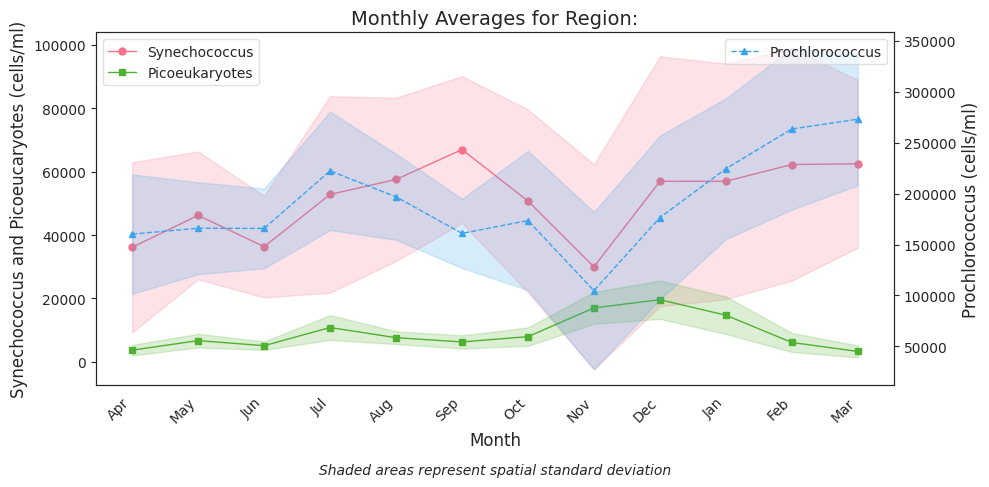

In [51]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Style
linewidth = 1
markersize = 5
sns.set_style("white")
palette = sns.color_palette("husl", 3)

months = monthly_means["month"].values
month_names = [
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
    "Jan",
    "Feb",
    "Mar",
]  # Manually change if different range

# Left axis
ax1.plot(
    months,
    monthly_means["syncoccus_moana"].values,
    "o-",
    color=palette[0],
    label="Synechococcus",
    linewidth=linewidth,
    markersize=markersize,
)
ax1.fill_between(
    months,
    monthly_means["syncoccus_moana"] - monthly_stds["syncoccus_moana"],
    monthly_means["syncoccus_moana"] + monthly_stds["syncoccus_moana"],
    color=palette[0],
    alpha=0.2,
)

ax1.plot(
    months,
    monthly_means["picoeuk_moana"].values,
    "s-",
    color=palette[1],
    label="Picoeukaryotes",
    linewidth=linewidth,
    markersize=markersize,
)
ax1.fill_between(
    months,
    monthly_means["picoeuk_moana"] - monthly_stds["picoeuk_moana"],
    monthly_means["picoeuk_moana"] + monthly_stds["picoeuk_moana"],
    color=palette[1],
    alpha=0.2,
)

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(
    months,
    monthly_means["prococcus_moana"].values,
    "^--",
    color=palette[2],
    label="Prochlorococcus",
    linewidth=linewidth,
    markersize=markersize,
)
ax2.fill_between(
    months,
    monthly_means["prococcus_moana"] - monthly_stds["prococcus_moana"],
    monthly_means["prococcus_moana"] + monthly_stds["prococcus_moana"],
    color=palette[2],
    alpha=0.2,
)

# Add labels, titles and improve x-axis
ax1.set_xlabel("Month", fontsize=12)
ax1.set_ylabel("Synechococcus and Picoeucaryotes (cells/ml)", fontsize=12)
ax2.set_ylabel("Prochlorococcus (cells/ml)", fontsize=12)
ax1.set_xticks(range(1, 13))  # manually change if different months on x axis
ax1.set_xticklabels(month_names)

ax1.legend(loc="upper left", frameon=True, framealpha=0.6)
ax2.legend(loc="upper right", frameon=True, framealpha=0.6)

plt.title(f"Monthly Averages for Region:", fontsize=14)
fig.text(
    0.5,
    0.01,
    "Shaded areas represent spatial standard deviation",
    ha="center",
    fontsize=10,
    style="italic",
)

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for the note
plt.show()

# Attempt at Hovmoller Diagram
## Still figuring this out!!!!


In [46]:
# Load in data tables from Olivia's processing
pro_df = pd.read_csv('prococcus_monthly_stats_normalized.csv')
pro_df

,month_year,Lat,Lon,cv,mean,median,std,value
0,Apr 2024,-48.199,-52.692,0.203220,0.212030,0.161927,0.413294,prococcus
1,Apr 2024,-48.115,-52.572,0.153168,0.267295,0.307108,0.392693,prococcus
2,Apr 2024,-48.014,-52.436,0.098673,0.381019,0.481549,0.360611,prococcus
3,Apr 2024,-47.933,-52.353,0.085281,0.393336,0.357893,0.321743,prococcus
4,Apr 2024,-47.860,-52.236,0.089379,0.422539,0.464721,0.362241,prococcus
...,...,...,...,...,...,...,...,...
8933,Sep 2024,11.790,-27.795,0.015499,0.755445,0.753504,0.112303,prococcus
8934,Sep 2024,11.976,-27.841,0.017235,0.775067,0.775067,0.128129,prococcus
8935,Sep 2024,12.355,-27.937,0.018653,0.721446,0.706888,0.129077,prococcus
8936,Sep 2024,6.256,-26.381,0.000000,0.530973,0.530973,0.000000,prococcus


In [48]:
# from datetime import datetime

# month_year_data= pro_df.month_year
# date_object = datetime.strptime(month_year_data, "%b %Y")
# numerical_date_string = date_object.strftime("%Y-%m-%d")
# print(numerical_date_string)

# min(pro_df.Lat), max(pro_df.Lat), min(pro_df.Lon), max(pro_df.Lon)

# # Define custom bin edges
# lat_bins = np.arange(-50, 50, 1)
# # date_bin_edges

# counts, bin_edges = np.histogram(data, bins=lat_bins)
# print("Bin Counts:", counts)
# print("Bin Edges:", bin_edges)


# # counts, date_bin_edges, lat_bin_edges = np.histogram2d(pro_df.datenum, pro_df.Lat), bins=[date_bin_edges, lat_bin_edges])

# # Use numpy's histogram function
# hist_counts, bins_returned = np.histogram(pro_df, bins=lat_bin_edges)
# print("Histogram counts:", hist_counts)
# print("Bin edges:", bins_returned)

(-48.199, 49.638, -52.692, -5.502)

In [63]:
# lat_bins = np.arange(-50, 52, 1)
# counts, bin_edges = np.histogram(pro_df.Lat, bins=lat_bins)
# bin_indices = np.digitize(pro_df.Lat, bins=lat_bins)
# print("Bin Counts:", counts)
# print("Bin Edges:", bin_edges)
# print("Bin Indices:", bin_indices)

# pro_df['lat_bin_idx']=bin_indices
# pro_df

# pro_df_grouped = pro_df.groupby('lat_bin_idx')
# pro_df_grouped

# pro_df_lat_average = pro_df_grouped['mean'].mean() # 'mean' column is the prochlorococcus data we want to average over latitudes

# pro_df_lat_average

# # Calculate the sum of values in each bin
# sum_per_bin = np.bincount(bin_indices, weights=pro_df.mean)

# # Calculate the count of points in each bin
# count_per_bin = np.bincount(bin_indices)

# # Calculate the average (handle division by zero for empty bins)
# average_per_bin = np.divide(sum_per_bin, count_per_bin, out=np.full_like(sum_per_bin, np.nan, dtype=float), where=count_per_bin != 0)

# print("Average points per bin:", average_per_bin)

Bin Counts: [  0  37 143 125 137 117 143 118 128 128 182 130 114 117  90 125 142 117
 146 118 108 107 138 124 108  92  91  78  65  91  79 209  98  81  80  82
  83  98  84  84  84  84  96  80  63  80  94  68  95  81  13   0   0  50
  68  57  45  43  47  48  55  76  52  64  52  73  54  61  70  86  73  70
  72  76  78  89  91  78  91  92  78  78  95  95  79  91 104 103  76 104
  91  77 117  91  89  89  88 127 167 113   0]
Bin Edges: [-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51]
Bin Indices: [ 2  2  2 ... 63 57 58]


lat_bin_idx
2      0.199124
3      0.235005
4      0.275253
5      0.298970
6      0.292708
         ...   
96     0.317528
97     0.323962
98     0.307362
99     0.276158
100    0.203423
Name: mean, Length: 97, dtype: float64

In [58]:
# from datetime import datetime

# month_year_data= pro_df.month_year
# date_object = datetime.strptime(month_year_data, "%b %Y")
# numerical_date_string = date_object.strftime("%Y-%m-%d")
# print(numerical_date_string)

[back to top](#Contents)

<div class="alert alert-info" role="alert">
    
You have completed the notebook on PACE data visualization!

</div>